In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [3]:
import classifier_utils as utils

In [4]:
import cv2

In [5]:
np.seterr(divide='ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

# Import SVM Implementation

In [173]:
# TODO: shouldn't polute the namespace like this, svm is a pretty short prefix!
from svm import get_gradient
from svm import get_activations
from svm import get_cost
from svm import get_cost_and_gradient
from svm import training_step
from svm import get_multiclass_predictions
from svm import train_loop
from svm import get_np_weighted_f1
from svm import status_report
from svm import multiclass_train_loop

# Simple Dataset SVM Example

In [164]:
data = np.array([[-4, 10], # class 0
                 [1, 10],
                 [-6, 8],
                 [-3, 8],
                 [3, 8],
                 [-1, 7],
                 [-4, 5],
                 [0, 5],
                 [-6, 3],
                 [-2, 2],
                 [-6, 1],
                 [-5, -1],
                 [-7, -2],
                 [-6, -4],
                 
                 [-1, -2], # class 1
                 [-4, -5],
                 [-1, -5],
                 [1, -5],
                 [-6, -7],
                 [-2, -7],
                 [1, -7],
                 [3, -7],
                 [-4, -8],
                 [1, -9],
                 [5, -9],
                 [-7, -10],
                 [-4, -10],
                 [-2, -10],
                 
                 [7, 10], # class 2
                 [6, 7],
                 [7, 6],
                 [3, 5],
                 [5, 4],
                 [7, 3],
                 [2, 2],
                 [5, 2],
                 [5, 0],
                 [2, -1],
                 [7, -1],
                 [5, -2],
                 [5, -4],
                 [7, -6]])         
labels = np.array([[1, 0, 0]]*14 + [[0, 1, 0]]*14 + [[0, 0, 1]]*14)

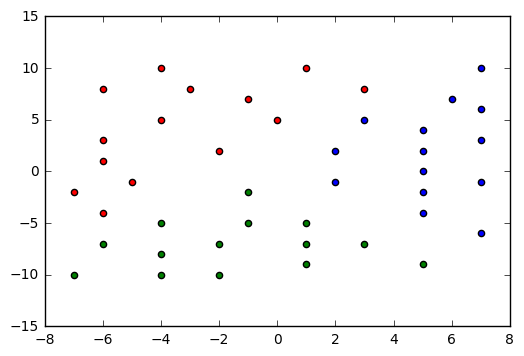

In [165]:
# Plot dataset
plt.scatter(data[:14,0], data[:14,1], c='r')
plt.scatter(data[14:28,0], data[14:28,1], c='g')
plt.scatter(data[28:,0], data[28:,1], c='b')

In [172]:
# Run SVM
C = 10
learning_rate = 0.003
batch_size = 2800 # Just some really big number to mean "the entire dataset in one batch"
epochs = 1000
ws = multiclass_train_loop(data, labels, data, labels, data, labels, C, learning_rate, batch_size, epochs, quiet=True)
print ws

Epoch FINAL, step FINAL:
	train loss [1.0913469653460335, 2.5954427415520955, 2.5829900778049462],
	validation loss [1.0913469653460335, 2.5954427415520955, 2.5829900778049462],
	test loss [1.0913469653460335, 2.5954427415520955, 2.5829900778049462],
	per-category test accuracy [ 1.          0.90476191  0.90476191],
	overall validation accuracy 1.000000,
	overall test accuracy 1.000000,
	validation f1 1.000000,
	test f1 1.000000
[[-0.55644254 -0.0645514   0.39326842]
 [ 0.4173721  -0.29224589  0.06284798]
 [-0.72548389 -0.8712765  -0.83905256]]


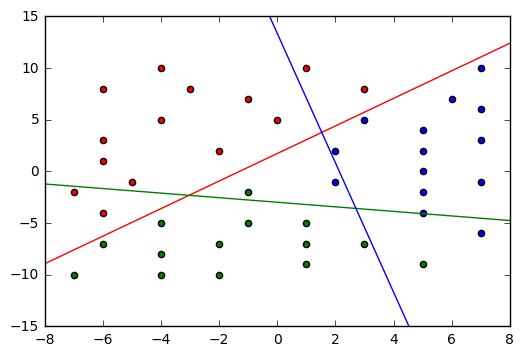

In [174]:
# Visualize results
# Dots are correctly classifier, crosses are incorrectly classifier
# Coloured lines are decision boundaries for each classifier
(predictions, _) = get_multiclass_predictions(data, ws)
actual = np.argmax(labels, axis=1)
correct = np.equal(predictions, actual)

mask = np.logical_and(correct, np.equal(actual, 0))
plt.scatter(data[mask, 0], data[mask,1], c='r')
mask = np.logical_and(np.logical_not(correct), np.equal(actual, 0))
plt.scatter(data[mask, 0], data[mask,1], c='r', marker='+')

mask = np.logical_and(correct, np.equal(actual, 1))
plt.scatter(data[mask, 0], data[mask,1], c='g')
mask = np.logical_and(np.logical_not(correct), np.equal(actual, 1))
plt.scatter(data[mask, 0], data[mask,1], c='g', marker='+')

mask = np.logical_and(correct, np.equal(actual, 2))
plt.scatter(data[mask, 0], data[mask,1], c='b')
mask = np.logical_and(np.logical_not(correct), np.equal(actual, 2))
plt.scatter(data[mask, 0], data[mask,1], c='b', marker='+')

plt.axis((-8, 8, -15, 15))

a, b, c = ws[:, 0]
x = np.linspace(-8, 8)
y = -a/b * x - c/b
plt.plot(x, y, c='r')

a, b, c = ws[:, 1]
x = np.linspace(-8, 8)
y = -a/b * x - c/b
plt.plot(x, y, c='g')

a, b, c = ws[:, 2]
x = np.linspace(-8, 8)
y = -a/b * x - c/b
plt.plot(x, y, c='b')

# Get Dataset

In [6]:
# To save memory, delete old dataset before creating new one
try:
    del test, train, validation # if they exist
except:
    pass

# Dataset
categories = [
    'epithelial',
    'fibroblast',
    'inflammatory',
    'others',
]
train, test = utils.get_augmented_dataset(categories)

# Carve out a validation set from our test set
# Split it 50/50
validation = {}
for k in list(test.iterkeys()):
    values = test[k]
    N = len(values)
    new_N = N/2
    test[k], validation[k] = np.split(values, [new_N])

Dropped 2082 patches because too close to image border


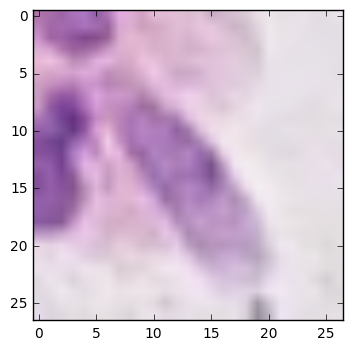

In [7]:
plt.imshow(train['patches'][0])

# Get HOG Features

In [8]:
def get_hog_features(hog, patches):
    N = patches.shape[0]
    descriptor_size = hog.getDescriptorSize()
    results = np.zeros((N, descriptor_size))
    for (i, patch) in enumerate(patches):
        uint_patch = (patch * 255).astype('uint8')
        resized_patch = cv2.resize(uint_patch, winSize, interpolation=cv2.INTER_LINEAR)
        feature_vector = hog.compute(resized_patch)[:, 0]
        results[i] = feature_vector
    return results

In [9]:
# Compute HOG descriptors for each test/train example

# Specify HOG parameters
winSize = (32, 32)
blockSize = (16, 16)
blockStride = (8, 8)
cellSize = (8, 8)
nbins = 9
hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)

# Get training descriptors
train['hog_features'] = get_hog_features(hog, train['patches'])

# Get validation descriptors
validation['hog_features'] = get_hog_features(hog, validation['patches'])

# Get test descriptors
test['hog_features'] = get_hog_features(hog, test['patches'])

# Load Autoencoder Features

In [12]:
train['autoencodings'] = np.load("train_autoencodings.npy")
test_encodings = np.load("test_autoencodings.npy")

# Split test encodings into validation and test
new_N = test['patches'].shape[0]
test['autoencodings'], validation['autoencodings'] = np.split(test_encodings, [new_N])

In [13]:
for (k, v) in train.iteritems():
    print "train", k, v.shape
for (k, v) in validation.iteritems():
    print "validation", k, v.shape
for (k, v) in test.iteritems():
    print "test", k, v.shape

train hog_features (60000, 324)
train hsv_factors (60000, 3)
train deltas (60000, 2)
train patches (60000, 27, 27, 3)
train rots (60000,)
train labels (60000, 4)
train flips (60000,)
train centres (60000, 2)
train autoencodings (60000, 128)
train img_ids (60000,)
validation hog_features (2037, 324)
validation patches (2037, 27, 27, 3)
validation labels (2037, 4)
validation centres (2037, 2)
validation autoencodings (2037, 128)
validation img_ids (2037,)
test hog_features (2036, 324)
test patches (2036, 27, 27, 3)
test labels (2036, 4)
test centres (2036, 2)
test autoencodings (2036, 128)
test img_ids (2036,)


# Functions for Model Selection

In [104]:
def output_global_status(C, prefix):
    # Helper function to access per-category time series
    def g(series, category):
        return [x[category] for x in series]
    
    def save_plot(suffix):
        full_dir = os.path.join(prefix, suffix)
        full_name = os.path.join(full_dir, "C=%010.4f.png" % C)
        if not os.path.exists(full_dir):
            os.makedirs(full_dir)
        plt.savefig(full_name)
        plt.clf()

    best_by_f1 = np.argmax(val_f1)
    print "Best according to f1: index %d, val f1 %f, test f1 %f" % (
        best_by_f1, val_f1[best_by_f1], test_f1[best_by_f1])
    best_by_acc = np.argmax(val_accuracy)
    print "Best according to accuracy: index %d, val acc %f, test acc %f" % (
        best_by_acc, val_accuracy[best_by_acc], test_accuracy[best_by_acc])

    x = range(len(g(loss, 0)))
    plt.plot(x, g(loss, 0), 'r')
    plt.plot(x, g(loss, 1), 'g')
    plt.plot(x, g(loss, 2), 'b')
    plt.plot(x, g(loss, 3), 'y')
    plt.title("C = %f, train loss" % C)
    save_plot("train_loss")
    x = range(len(g(test_loss, 0)))
    plt.plot(x, g(test_loss, 0), 'r')
    plt.plot(x, g(test_loss, 1), 'g')
    plt.plot(x, g(test_loss, 2), 'b')
    plt.plot(x, g(test_loss, 3), 'y')
    plt.title("C = %f, test loss" % C)
    save_plot("test_loss")
    x = range(len(g(val_loss, 0)))
    plt.plot(x, g(val_loss, 0), 'r')
    plt.plot(x, g(val_loss, 1), 'g')
    plt.plot(x, g(val_loss, 2), 'b')
    plt.plot(x, g(val_loss, 3), 'y')
    plt.title("C = %f, val loss" % C)
    save_plot("val_loss")

    plt.plot(x, val_accuracy)
    plt.title("C = %f, overall val accuracy" % C)
    save_plot("overall_val_accuracy")

    plt.plot(x, test_accuracy)
    plt.title("C = %f, overall test accuracy" % C)
    save_plot("overall_test_accuracy")

    plt.plot(x, val_f1)
    plt.title("C = %f, overall val f1" % C)
    save_plot("overall_val_f1")

    plt.plot(x, test_f1)
    plt.title("C = %f, overall test f1" % C)
    save_plot("overall_test_f1")
    
    return (best_by_f1, best_by_acc)

In [108]:
def svm_C_search(train, validation, test, feature_name, learning_rate, batch_size, epochs, Cs, prefix):
    results = {
        'Cs' : [],
        'best_validation_f1_index': [],
        'best_validation_accuracy_index': [],
        'best_ws_by_validation_f1': [],
        'best_ws_by_validation_accuracy': [],
        'best_validation_f1': [],
        'best_validation_accuracy': [],
        'test_f1_at_best': [],
        'test_accuracy_at_best': [],
    }

    # Run SVM with various values of C
    for C in Cs:
        print "C=%f" % C
        multiclass_train_loop(train[feature_name], train['labels'],
                              validation[feature_name], validation['labels'],
                              test[feature_name], test['labels'],
                              C, learning_rate, batch_size, epochs,
                              quiet=True)
        (f1_index, accuracy_index) = output_global_status(C, prefix)
        results['Cs'].append(C)
        results['best_validation_f1_index'].append(f1_index)
        results['best_validation_accuracy_index'].append(accuracy_index)
        results['best_ws_by_validation_f1'].append(params[f1_index])
        results['best_ws_by_validation_accuracy'].append(params[accuracy_index])
        results['best_validation_f1'].append(val_f1[f1_index])
        results['best_validation_accuracy'].append(val_accuracy[accuracy_index])
        results['test_f1_at_best'].append(test_f1[f1_index])
        results['test_accuracy_at_best'].append(test_accuracy[accuracy_index])
        print ""
        print ""
        
    # Print a summary message and return the results
    best_f1_C_index = np.argmax(results['best_validation_f1'])
    best_accuracy_C_index = np.argmax(results['best_validation_accuracy'])
    print "OVERALL"
    print "Best f1 is at index %d, best accuracy is at index %d" % (best_f1_C_index, best_accuracy_C_index)
    
    return results

# Apply SVM to HOG Features

In [109]:
# Run SVM with various values of C
learning_rate = 0.0003
batch_size = 200
epochs = 100
# Recommended to try C in range 2^{-5 ... 15} from http://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf
Cs = [2.0**x for x in xrange(-5, 16)]
hog_results = svm_C_search(
    train, validation, test, 'hog_features', learning_rate, batch_size, epochs, Cs, 'svm_graphs/hog')

C=0.031250
Epoch FINAL, step FINAL:
	train loss [0.93757431889834697, 0.94320979211973266, 0.94145912114934349, 0.93100369438266339],
	validation loss [0.96191322626324061, 0.93730258325823979, 0.95700604343464635, 0.8953521640973835],
	test loss [0.96439740055347967, 0.93936292416534817, 0.94933082431062188, 0.89901808869382549],
	per-category test accuracy [ 0.65324163  0.73330057  0.70825148  0.90520626],
	overall validation accuracy 0.348552,
	overall test accuracy 0.356582,
	validation f1 0.000000,
	test f1 0.000000
Best according to f1: index 461, val f1 0.301271, test f1 0.000000
Best according to accuracy: index 520, val acc 0.405498, test acc 0.391945


C=0.062500
Epoch FINAL, step FINAL:
	train loss [0.87697594519490507, 0.88861971406686191, 0.8847249641299425, 0.86385033132197508],
	validation loss [0.925705210129666, 0.87680324816014465, 0.91584422838252111, 0.79249785092961533],
	test loss [0.93068092166525007, 0.88092038957203322, 0.90047624715512642, 0.79983486991753727]

In [154]:
# Store results
#import pickle
#with open('hog_svn_results.p', 'wb') as f:
#    pickle.dump(hog_results, f)
#np.save('hog_svn_best_ws.npy', np.hstack(hog_results['best_ws_by_validation_f1'][16]))

In [157]:
# Restore results
import pickle
with open('hog_svn_results.p', 'rb') as f:
    hog_results = pickle.load(f)

In [160]:
print hog_results['test_accuracy_at_best'][16]
print hog_results['test_f1_at_best'][16]

0.556483
0.526957574876


In [162]:
hog_ws = np.hstack(hog_results['best_ws_by_validation_f1'][16])
hog_predictions, _ = get_multiclass_predictions(test['hog_features'], hog_ws)
hog_actuals = np.argmax(test['labels'], axis=1)
print np.count_nonzero(np.equal(hog_predictions, hog_actuals)) / float(len(hog_actuals))
print get_np_weighted_f1(hog_predictions, hog_actuals, 4)

0.548133595285
0.526957574876


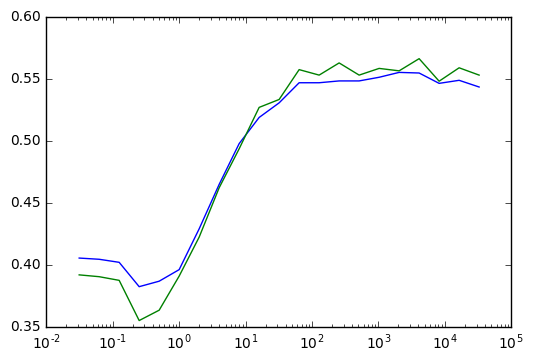

In [120]:
plt.plot(hog_results['Cs'], hog_results['best_validation_accuracy'])
plt.plot(hog_results['Cs'], hog_results['test_accuracy_at_best'])
plt.xscale('log')

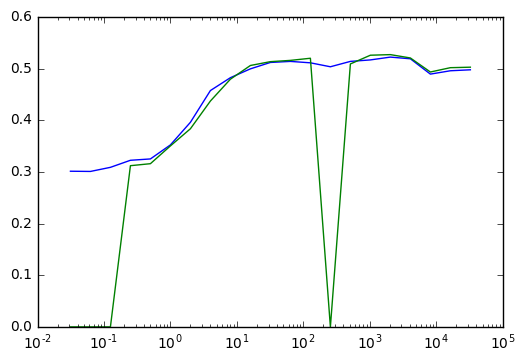

In [116]:
plt.plot(hog_results['Cs'], hog_results['best_validation_f1'])
plt.plot(hog_results['Cs'], hog_results['test_f1_at_best'])
plt.xscale('log')

In [164]:
(predictions, _) = get_multiclass_predictions(validation['hog_features'], ws)
print np.count_nonzero(np.equal(predictions, 0))
print np.count_nonzero(np.equal(predictions, 1))
print np.count_nonzero(np.equal(predictions, 2))
print np.count_nonzero(np.equal(predictions, 3))

832
921
284
0


# Apply SVM to Autoencoder Features

In [121]:
# Run SVM with various values of C
learning_rate = 0.0001
batch_size = 200
epochs = 200 # Many of these take longer to converge than HOG, so run for 200 epochs
# Recommended to try C in range 2^{-5 ... 15} from http://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf
Cs = [2.0**x for x in xrange(-5, 16)]
auto_results = svm_C_search(
    train, validation, test, 'autoencodings', learning_rate, batch_size, epochs, Cs, 'svm_graphs/auto')

C=0.031250
Epoch FINAL, step FINAL:
	train loss [0.48306666754151234, 0.56559703485047208, 0.52768221598350684, 0.44738419664530799],
	validation loss [0.67254602137264818, 0.52245645157260334, 0.65267284963130723, 0.16811952186764575],
	test loss [0.69119224961571202, 0.53873612779644864, 0.59048722553307398, 0.19630633019448596],
	per-category test accuracy [ 0.65324163  0.73330057  0.70825148  0.90520626],
	overall validation accuracy 0.493864,
	overall test accuracy 0.479371,
	validation f1 0.498216,
	test f1 0.483056
Best according to f1: index 1197, val f1 0.503387, test f1 0.495606
Best according to accuracy: index 1199, val acc 0.500736, test acc 0.495088


C=0.062500
Epoch FINAL, step FINAL:
	train loss [0.48136259502036527, 0.5646233698598393, 0.52583715295854261, 0.44609885449173153],
	validation loss [0.66930952343887473, 0.52133710669413791, 0.6503778990013237, 0.16687085541815269],
	test loss [0.68767973112097525, 0.53759780879397179, 0.58812941235506588, 0.19499983504789

In [146]:
# Store results
#import pickle
#with open('auto_svn_results.p', 'wb') as f:
#    pickle.dump(auto_results, f)
#np.save('auto_svn_best_ws.npy', np.hstack(auto_results['best_ws_by_validation_f1'][10]))

In [147]:
# Restore results
import pickle
with open('auto_svn_results.p', 'rb') as f:
    auto_results = pickle.load(f)

In [149]:
print auto_results['test_accuracy_at_best'][10]
print auto_results['test_f1_at_best'][10]

0.663065
0.657819415973


In [153]:
auto_ws = np.hstack(auto_results['best_ws_by_validation_f1'][10])
auto_predictions, _ = get_multiclass_predictions(test['autoencodings'], auto_ws)
#print auto_predictions[:100]
auto_actuals = np.argmax(test['labels'], axis=1)
#print auto_actuals[:100]
print np.count_nonzero(np.equal(auto_predictions, auto_actuals)) / float(len(auto_actuals))
print get_np_weighted_f1(auto_predictions, auto_actuals, 4)

0.669941060904
0.657819415973


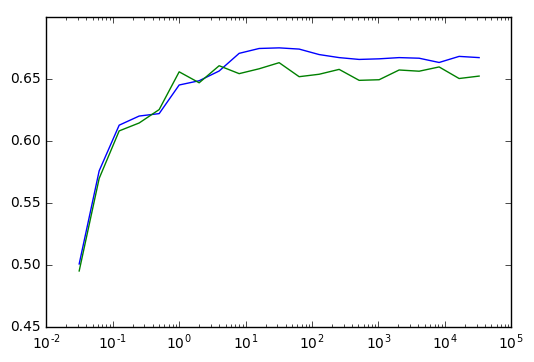

In [122]:
plt.plot(auto_results['Cs'], auto_results['best_validation_accuracy'])
plt.plot(auto_results['Cs'], auto_results['test_accuracy_at_best'])
plt.xscale('log')

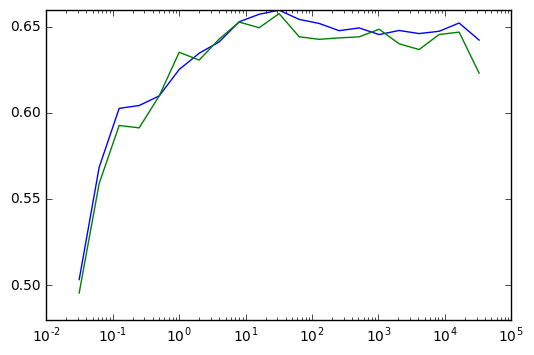

In [125]:
plt.plot(auto_results['Cs'], auto_results['best_validation_f1'])
plt.plot(auto_results['Cs'], auto_results['test_f1_at_best'])
plt.xscale('log')

# Junk

C=1.000000
Epoch FINAL, step FINAL:
	train loss [0.48333337472196758, 0.56445071871453023, 0.52567157117382857, 0.44744865087981756],
	validation loss [0.63314389695180617, 0.52135291512414472, 0.65032478768535362, 0.16763029246944464],
	test loss [0.64659401659418625, 0.53754666294183573, 0.5864534762016308, 0.19619503666598201],
	per-category test accuracy [ 0.65324163  0.73330057  0.70825148  0.90520626],
	overall validation accuracy 0.504173,
	overall test accuracy 0.528978,
	validation f1 0.000000,
	test f1 0.000000
Best according to f1: index 0, val f1 0.000000, test f1 0.000000
Best according to accuracy: index 1080, val acc 0.645066, test acc 0.655697




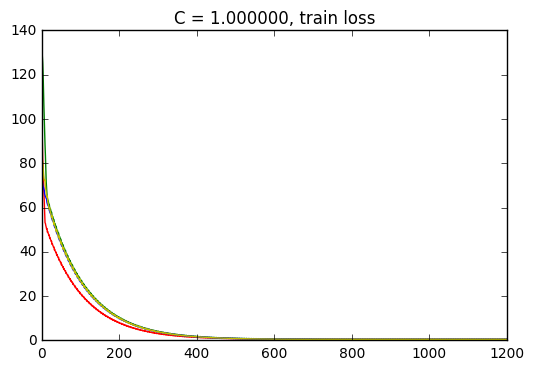

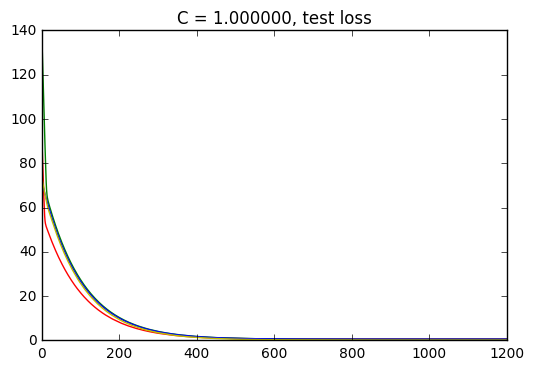

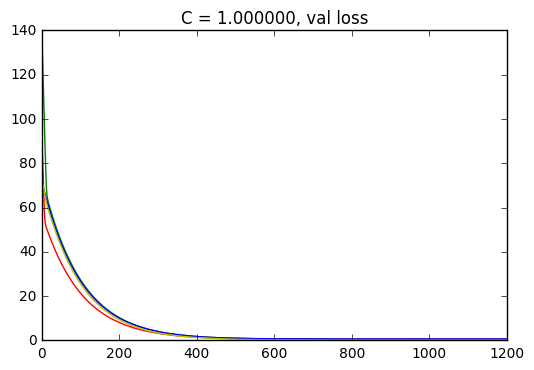

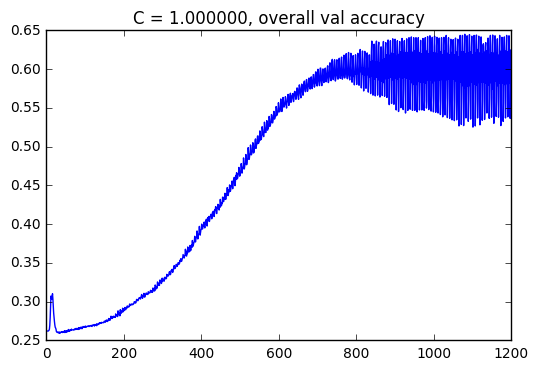

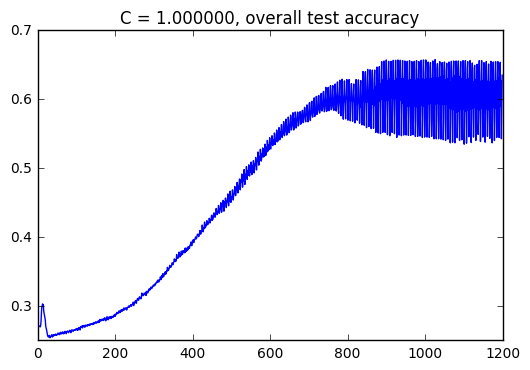

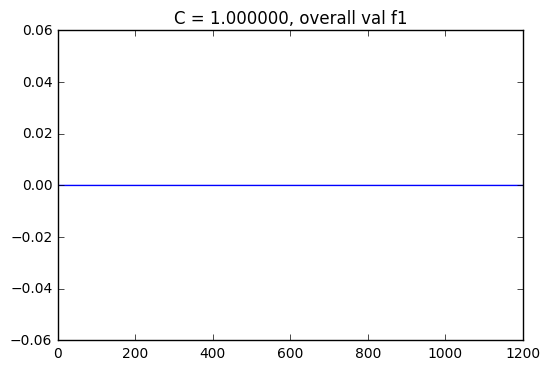

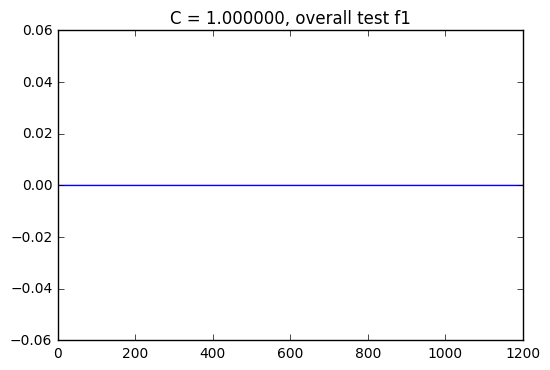

In [61]:
# Run SVM with C=1
learning_rate = 0.0001
batch_size = 200
epochs = 200 # Many of these take longer to converge than HOG, so run for 200 epochs
# Recommended to try C in range 2^{-5 ... 15} from http://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf
C=1
print "C=%f" % C
ws = multiclass_train_loop(train['autoencodings'], train['labels'],
                           validation['autoencodings'], validation['labels'],
                           test['autoencodings'], test['labels'],
                           C, learning_rate, batch_size, epochs,
                           quiet=True)
output_global_status(C)
print ""
print ""

In [62]:
print np.count_nonzero(np.equal(np.argmax(test['labels'], axis=1), 0))
print np.count_nonzero(np.equal(np.argmax(test['labels'], axis=1), 1))
print np.count_nonzero(np.equal(np.argmax(test['labels'], axis=1), 2))
print np.count_nonzero(np.equal(np.argmax(test['labels'], axis=1), 3))

706
543
594
193


In [69]:
my_ws = np.hstack(params[1080])
(my_predictions, my_per_class_predictions) = get_multiclass_predictions(test['autoencodings'], my_ws)
print np.count_nonzero(np.equal(my_predictions, 0))
print np.count_nonzero(np.equal(my_predictions, 1))
print np.count_nonzero(np.equal(my_predictions, 2))
print np.count_nonzero(np.equal(my_predictions, 3))

908
504
579
45


In [77]:
get_np_weighted_f1(my_predictions, np.argmax(test['labels'], axis=1), 4)

Label 0
TP 615
PL 706
PP 908
Recall 0.871104815864
Precision 0.67731277533
F1 0.762081784387
Label 1
TP 302
PL 543
PP 504
Recall 0.556169429098
Precision 0.599206349206
F1 0.576886341929
Label 2
TP 391
PL 594
PP 579
Recall 0.658249158249
Precision 0.67530224525
F1 0.666666666667
Label 3
TP 27
PL 193
PP 45
Recall 0.139896373057
Precision 0.6
F1 0.226890756303
Total weight 2036.0
Weights [0.3467583497053045, 0.26669941060903735, 0.2917485265225933, 0.09479371316306483]
F1_avg 0.634120304229


0.6341203042293516